In [1]:
import math
import qiskit_qasm2
from qiskit_qasm2 import load, CustomClassical
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm, matrix_power
from functools import reduce
from itertools import product
from matplotlib.ticker import MaxNLocator
import time

PAULIS = {'I': np.eye(2, dtype='complex'),
          'X': np.array([[0, 1], [1, 0]], dtype='complex'),
          'Y': np.array([[0, -1j], [1j, 0]]),
          'Z': np.diag(np.array([1, -1], dtype='complex'))}

## for higher order the coefficients are of order 10^24/10^28
B_sign = {2: (np.array([-1,0,1]),2), # Accuracy is O(h^2)
          4: (np.array([1,-8,0,8,-1]),12), # Accuracy is O(h^4)
          6: (np.array([-1,9,-45,0,45,-9,1]),60), # Accuracy is O(h^6)
          8: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840), # Accuracy is O(h^8)
          10: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)} # Accuracy is O(h^10)


def make_B_symm(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase

def make_B_zeros(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)
    return B/cbase


def pad_with_zeros(arr, n):
    padded = np.zeros(2**n)
    num_zeros = 2**n - len(arr)
    if num_zeros == 0:
        return arr
    assert num_zeros > 0 and num_zeros%2 == 0
    num_zeros = num_zeros//2
    padded[num_zeros:-num_zeros] = arr
    return padded

def get_error_symm(nq, acc_order, l, t, c_max):
    coef_B,cb_B = B_sign[acc_order]
    
    ######### Make B as prolonged symmetrically #########
    B_symm = make_B_symm(2**(nq),coef_B,cb_B)
    H_symm = np.block([[np.zeros_like(B_symm), B_symm],[B_symm.T, np.zeros_like(B_symm)]])
    
    ######### Make computational grid #########
    
    x_real = np.linspace(0,l,2**(nq))
    dx = x_real[1]-x_real[0]
    
    ######### Make propogators #########
    
    expm_H_symm = expm(-1j*H_symm*t/dx)

    ######### Make initial conditions #########
    """ Initial conditions (classic) """
    psi_init = np.sin(x_real*np.pi/l)
    dpsi_dt_init = np.zeros_like(x_real)
    
    """ Initial conditions (Schrodinger) """
    psi_0_sch = np.concatenate((psi_init, dpsi_dt_init))
#     psi_0_sch /= norm(psi_0_sch) # normalization
    
    
    ######### Generate solutions #########
    psi_final = np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution
#     psi_final /= norm(psi_final) # normalization
    
    psi_sch_final_symm = expm_H_symm@psi_0_sch # numerical solution
    psi_sch_final_symm = psi_sch_final_symm[:len(psi_sch_final_symm)//2].real
#     psi_sch_final_symm /= norm(psi_sch_final_symm) # normalization
    
    return norm(psi_sch_final_symm - psi_final)**2

def get_error_zeros(nq, acc_order, l, t, c_max):
    coef_B,cb_B = B_sign[acc_order]
    
    ######### Make B as prolonged with zeros #########
    B_zeros = make_B_zeros(2**(nq),coef_B,cb_B)

    """ Explicit boundary conditions """
    for i in range(acc_order//2): # zero boundary conditions
        B_zeros[i,:] = np.zeros_like(B_zeros[i,:])
        B_zeros[-(i+1),:] = np.zeros_like(B_zeros[-(i+1),:])
        
    H_zeros = np.block([[np.zeros_like(B_zeros), B_zeros],[B_zeros.T, np.zeros_like(B_zeros)]])  
    
    ######### Make computational grid #########
    num_additional_zeros = acc_order//2-1
    x_real = np.linspace(0,l,2**(nq)-2*num_additional_zeros)
    dx = x_real[1]-x_real[0]
    
    ''' x_comp made in the way, that for x=<0 and x>=l we have zeros in the matrix B. '''
    
    x_left = [-i*dx for i in range(1,num_additional_zeros+1)][::-1]
    x_right = [l+i*dx for i in range(1,num_additional_zeros+1)]
    x_comp = np.array(x_left + list(x_real) + x_right)
    assert len(x_comp) == 2**nq
    
    ######### Make propogators #########
    
    expm_H_zeros = expm(-1j*H_zeros*t/dx)

    ######### Make initial conditions #########
    """ Initial conditions (classic) """
    psi_init = A*np.sin(x_real*np.pi/l)
    dpsi_dt_init = np.zeros_like(x_real)
    
    """ Initial conditions (Schrodinger) """
    psi_0_sch = np.concatenate((pad_with_zeros(psi_init, nq), pad_with_zeros(dpsi_dt_init,nq)))
#     psi_0_sch /= norm(psi_0_sch) # normalization
    
    ######### Generate solutions #########
    psi_final = np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution
#     psi_final /= norm(psi_final) # normalization
    
    psi_sch_final_zeros = expm_H_zeros@psi_0_sch # numerical solution
    
    ######### Calculate error #########

    if num_additional_zeros == 0:
        psi_sch_final_zeros = psi_sch_final_zeros[:len(psi_sch_final_zeros)//2].real
    else:
        psi_sch_final_zeros = psi_sch_final_zeros[:len(psi_sch_final_zeros)//2].real[num_additional_zeros:-num_additional_zeros]
        
#     psi_sch_final_zeros /= norm(psi_sch_final_zeros) # normalization
    
    return norm(psi_sch_final_zeros - psi_final)**2

In [5]:
l = 1
t = 1
c_max = 1
A = 1

Nt = 10
t_list = np.linspace(0,t,Nt)

NQ = 8
nq = NQ - 1

acc_order_errors_symm = []
acc_order_errors_zeros = []
acc_order_list = [2,4,6,8,10]

for acc_order in acc_order_list:
    error_zeros_list = []
    error_symm_list = []
    for t_i in t_list:
        error_zeros = get_error_zeros(nq, acc_order, l, t_i, c_max)
        error_symm = get_error_symm(nq, acc_order, l, t_i, c_max)
        
        error_zeros_list.append(error_zeros)
        error_symm_list.append(error_symm)
        
    acc_order_errors_zeros.append(error_zeros_list)
    acc_order_errors_symm.append(error_symm_list)

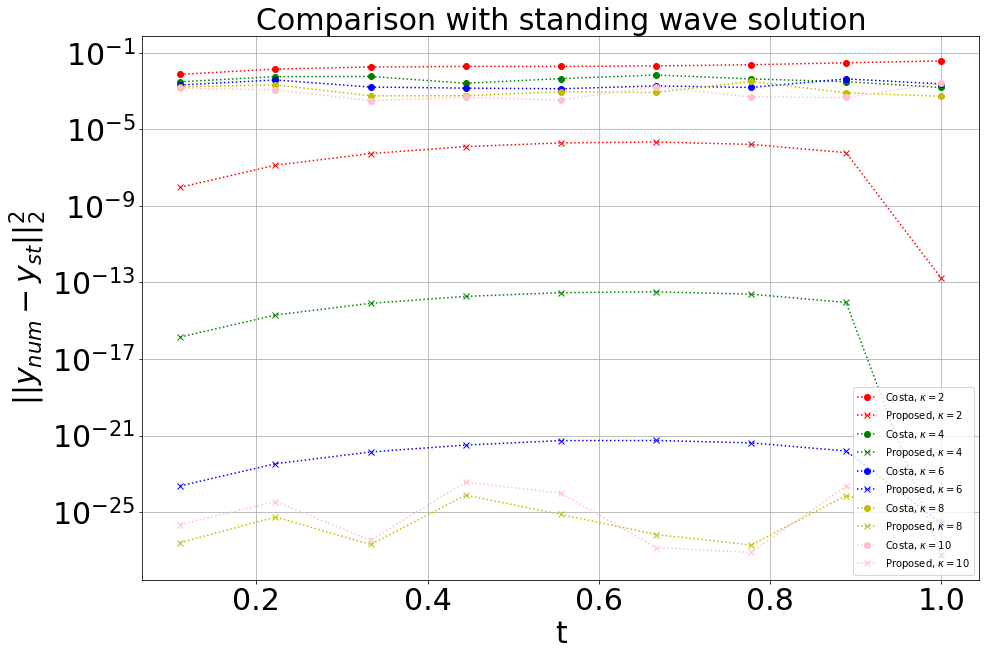

In [6]:
plt.figure(figsize=(15,10))
color_list = ['r','g','b','y','pink']
# color_list = ['r','g','b']
for acc_order, error_zeros_list, error_symm_list, c in zip(acc_order_list, acc_order_errors_zeros, acc_order_errors_symm, color_list):
    plt.plot(t_list[1:], error_zeros_list[1:], marker='o', c=c, label = 'Costa, '+'$\kappa = {}$'.format(acc_order), linestyle='dotted')
    plt.plot(t_list[1:], error_symm_list[1:], marker='x', c=c, label = 'Proposed, '+'$\kappa = {}$'.format(acc_order), linestyle='dotted')
        
plt.title("Comparison with standing wave solution", fontsize=30)
plt.ylabel('$|| y_{num} - y_{st}||_2^2$', fontsize=30)
plt.xlabel('t', fontsize=30)
plt.yscale('log')
plt.legend(loc='lower right',fontsize=10)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.grid(alpha = 1)

figFilename = "comparison_padding_with_zeros_and_symmetical_prolongation"
figFilename += "_NQ-{}_t-{}_l-{}.pdf".format(NQ, t, l)

plt.savefig(figFilename, format="pdf", bbox_inches="tight")